# ES304 - COMPLEX ENGINEERING PROBLEM

# Team: 2021750, 2021266, 2021250, 2021225

In [2]:
#installing rasterio library to open and manipulate jp2 multi-spectral images
#!pip install rasterio
#installing matplotlib for plotting images from arrays
#pip install matplotlib

In [3]:
# importing libraries for plotting 
import rasterio
from rasterio import plot
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

# TASK 1: CROPPING, CONCATENATING AND VISUALISING ALL BANDS

In [4]:
#defining the image paths for opening images
img1_path = "images/T42RXV_20231111T055051_AOT_10m.jp2"
img2_path = "images/T42RXV_20231111T055051_B02_10m.jp2"
img3_path = "images/T42RXV_20231111T055051_B03_10m.jp2"
img4_path = "images/T42RXV_20231111T055051_B04_10m.jp2"
img5_path = "images/T42RXV_20231111T055051_B08_10m.jp2"
img6_path = "images/T42RXV_20231111T055051_TCI_10m.jp2"
img7_path = "images/T42RXV_20231111T055051_WVP_10m.jp2"

#using raterio libary to open image 1 in compatible format and storing it in a variable named band1
band1 = rasterio.open(img1_path)

#displaying information about band 1
print("Number of bands in Image 1:", band1.count)
print("Number of columns (width) of Image 1:", band1.width)
print("Number of rows (height) of Image 1:", band1.height)

Number of bands in Image 1: 1
Number of columns (width) of Image 1: 10980
Number of rows (height) of Image 1: 10980


In [5]:
# Define the cropping parameters
crop_start_row = 7000
crop_start_col = 7000

# Function to crop an array
def crop_array(arr, start_row, start_col):
    return arr[start_row:, start_col:]

# List of JP2 file paths
jp2s = [img1_path, img2_path, img3_path, img4_path, img5_path, img6_path, img7_path]

# Initialize an empty list to store individual bands
arrs = []

# Loop through each JP2 file, read the band, and apply crop function
for jp2 in jp2s:
    with rasterio.open(jp2) as f:
        # Read the band information into an array
        arr = f.read(1)
        
        # Crop the array using the crop defined earlier
        cropped_arr = crop_array(arr, crop_start_row, crop_start_col)
        
        # Append the cropped array to the list of cropped arrays of all the bands
        arrs.append(cropped_arr)

# Stack the individual bands along the last axis to create a 3D array
stacked_image = np.stack(arrs, axis=-1)

(3980, 3980)


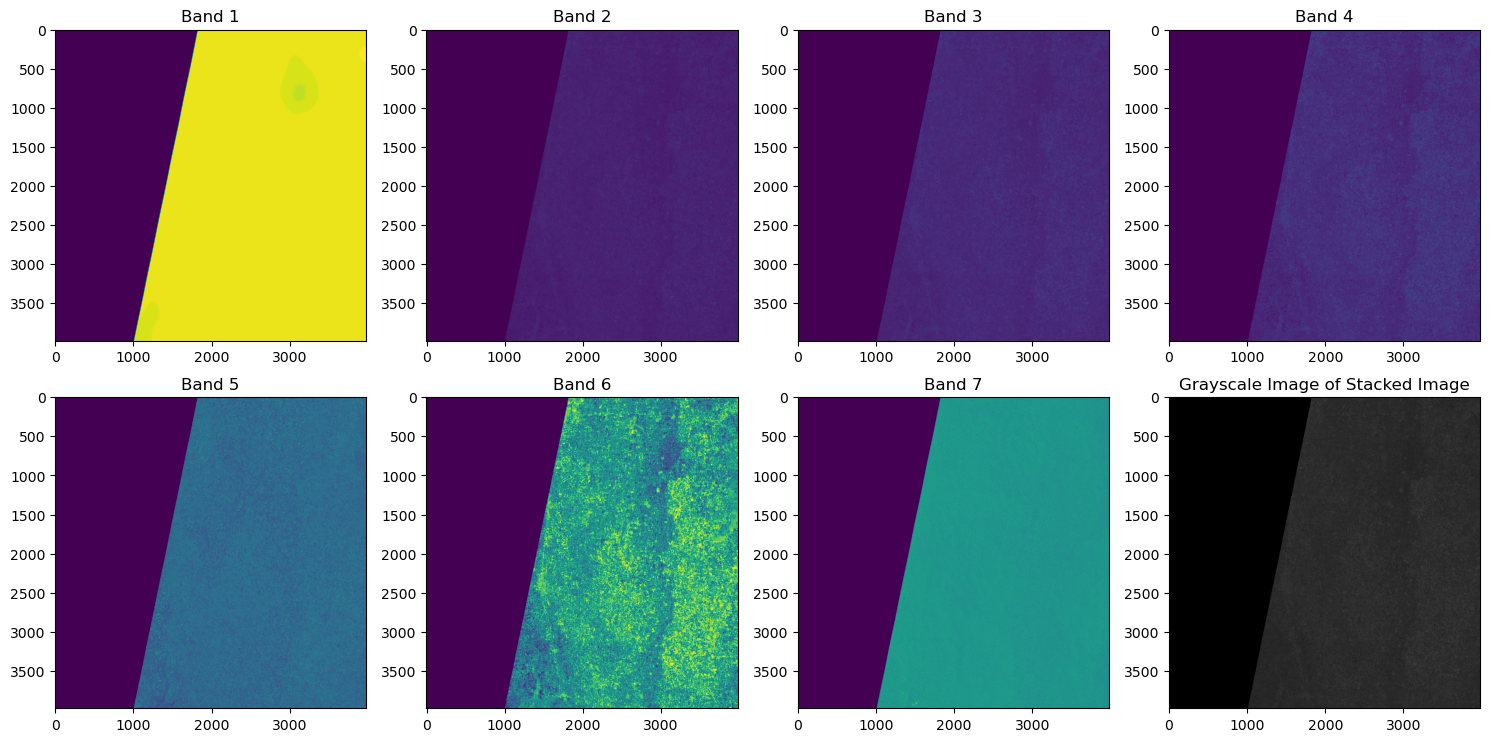

In [61]:
# Display each band using subplots
num_bands = 7

# Assigning the number of rows and columns for subplots
num_rows = 2
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7.5))

# Flatten the axes array
axes = axes.flatten()

# Display each band
for i in range(num_rows * num_cols - 1):  # Exclude the last subplot for the greyscale image
    axes[i].imshow(stacked_image[:, :, i])
    axes[i].set_title(f'Band {i + 1}')

# Calculate the mean of all bands (stacked_image) to create a grayscale image
grayscale_image_original = np.mean(stacked_image, axis=2)

# Display the greyscale image of the stacked_image in the last subplot
axes[-1].imshow(grayscale_image_original, cmap='gray')
axes[-1].set_title('Grayscale Image of Stacked Image')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

# TASK 2: APPLYING PRINCIPAL COMPONENT ANALYSIS TO THE MULTI-SPECTRAL IMAGE

In [57]:
#Reshaping the 3D array of stacked image into a 2D array to apply PCA
reshaped_arr = stacked_image.reshape(-1, stacked_image.shape[-1])
#Printing the size of reshaped_arr
print("Size of the 2D Reshaped Array:", reshaped_arr.shape)

#Standardize the reshaped data (scaling and centering) to ensure similar scales for all variables (bands)
standardized_arr = (reshaped_arr - np.mean(reshaped_arr, axis=0)) / np.std(reshaped_arr, axis=0, ddof=1)
print("Size of the Standardized Array:", standardized_arr.shape)

# Calculate the covariance matrix
#rowvar=False ensures that each column is treated as a variable
covariance_matrix = np.cov(standardized_arr, rowvar=False)

# Print the covariance matrix and its size
print("Size of the Covariance Matrix:", covariance_matrix.shape)

print("Covariance Matrix:")
for i in range(7):
    for j in range(7):
        print(f'{covariance_matrix[i, j]:.4f}', end='\t')
    print()

Size of the 2D Reshaped Array: (15840400, 7)
Size of the Standardized Array: (15840400, 7)
Size of the Covariance Matrix: (7, 7)
Covariance Matrix:
1.0000	0.9635	0.9641	0.9436	0.9747	0.8607	0.9915	
0.9635	1.0000	0.9986	0.9956	0.9495	0.9616	0.9575	
0.9641	0.9986	1.0000	0.9946	0.9550	0.9598	0.9598	
0.9436	0.9956	0.9946	1.0000	0.9269	0.9804	0.9351	
0.9747	0.9495	0.9550	0.9269	1.0000	0.8491	0.9844	
0.8607	0.9616	0.9598	0.9804	0.8491	1.0000	0.8523	
0.9915	0.9575	0.9598	0.9351	0.9844	0.8523	1.0000	


In [17]:
# Finding eigenvalues and eigenvectors for the Covariance Matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
num_bands = 7
# Sort eigenvalues and corresponding eigenvectors in descending order

# First we sort the indices according to the eigenvalues
desc_indices = np.argsort(eigenvalues)[::-1]

# Reorder eigenvalues based on sorted indices
eigenvalues = eigenvalues[desc_indices]

# Reorder eigenvectors based on sorted indices
eigenvectors = eigenvectors[:, desc_indices]

# Print eigenvalues and eigenvectors
print("Eigenvalues:")
for i in range(num_bands):
    print(f'{eigenvalues[i]:.4f}', end='\t')
    print()

print("\nEigenvectors:")
for i in range(num_bands):
    for j in range(num_bands):
        print(f'{eigenvectors[i, j]:.4f}', end='\t')
    print()

Eigenvalues:
6.7045	
0.2568	
0.0271	
0.0069	
0.0034	
0.0011	
0.0002	

Eigenvectors:
-0.3777	-0.3572	0.5699	0.4553	-0.3467	0.0429	-0.2750	
-0.3849	0.1364	0.1054	0.1284	0.5851	-0.6780	-0.0608	
-0.3852	0.1173	-0.0288	0.1232	0.5375	0.7288	-0.0427	
-0.3820	0.2842	0.1109	0.0608	-0.2710	-0.0052	0.8270	
-0.3744	-0.4105	-0.7783	0.2307	-0.1585	-0.0844	0.0031	
-0.3644	0.6501	-0.1470	-0.1947	-0.3874	-0.0129	-0.4847	
-0.3767	-0.4101	0.1535	-0.8162	0.0072	0.0061	0.0087	


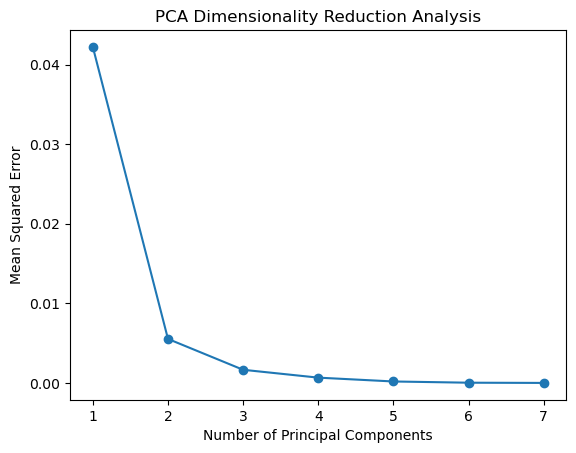

In [58]:
#Storing the number of Principal Components in an array
k_arr = [1, 2, 3, 4, 5, 6, 7]
#Used to store the mse for each value of k
pca_error = []

for i in k_arr:
    #Selects the number of eigenvectors corresponding to the number of Principal Components
    top_k_eigenvectors = eigenvectors[:, :i]
    
    #Multiplies the 2D reshaped stacked image(reshaped_arr) with the eigenvectors corresponding to the number of PCs
    #This reduces the spectral dimensionality of the image
    reduced_data = np.dot(standardized_arr, top_k_eigenvectors)

    #Reconstructs the data from the reduced representation to the original spectral space
    #Represents an approximation of the original data but with reduced dimensionality
    reconstructed_data = np.dot(reduced_data, top_k_eigenvectors.T)
    
    #Calculates the mean squared error for each value of k
    mse = mean_squared_error(standardized_arr, reconstructed_data)
    
    #Appends the mse for each value of k to pca_error for plotting
    pca_error.append(mse)

#Analyzing and interpreting the dimensionality reduction by plotting a graph of number of Principal Components against
#the respective mean squared error to decide suitable k value
plt.plot(k_arr, pca_error, marker='o')
plt.title("PCA Dimensionality Reduction Analysis")
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean Squared Error")
plt.show()

(3980, 3980)


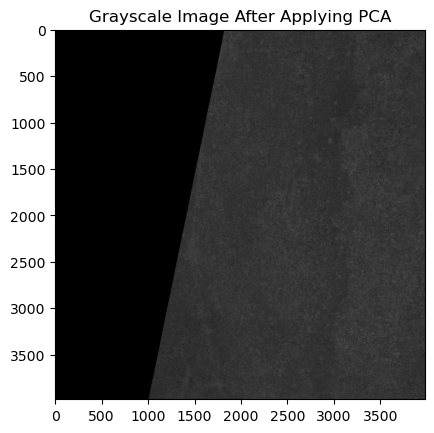

In [60]:
#Selecting the value of k as 2 since it's the elbow point of the graph
k = 2

# Select the top 2 eigenvectors
top_k_eigenvectors = eigenvectors[:, :k]

#Multiplies the 2D reshaped stacked image(standardized_arr) with the top 2 eigenvectors to reduce dimensions
reduced_data = np.dot(standardized_arr, top_k_eigenvectors)

# Reconstruct the data from the reduced representation to the original spectral space
reconstructed_data = np.dot(reduced_data, top_k_eigenvectors.T)

#Storing the size of original 3D array for converting data back to 3D
original_shape = stacked_image.shape

# Reshape back to 3D
reduced_3D_array = reconstructed_data.reshape(original_shape)

# Calculate the mean of all bands to create a grayscale output image
output_image = np.mean(reduced_3D_array, axis=2)
print(output_image.shape)
# Display the grayscale output image
plt.imshow(output_image, cmap='gray')
plt.title('Grayscale Image After Applying PCA')
plt.show()

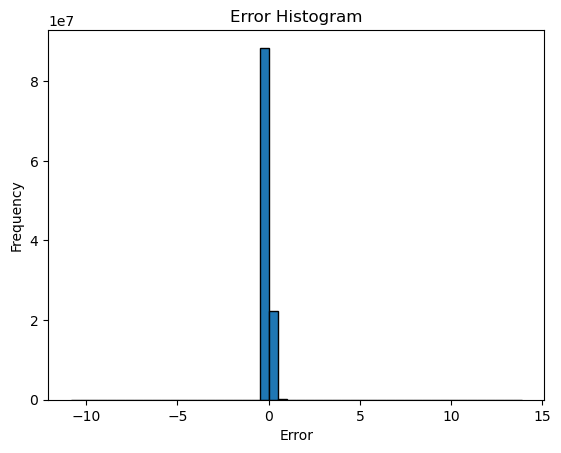

In [25]:
# Calculate the error for each data point by finding the difference before and after applying PCA
errors = standardized_arr - reconstructed_data

#Create a histogram
plt.hist(errors.flatten(), bins=50, edgecolor='black')
plt.title("Error Histogram")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()